In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


train_data = pd.read_csv("data_vectorized.csv")

In [2]:
tokens = train_data["tokens"].apply(eval)

flat_tokens = []
for i in tokens:
    flat_tokens.extend(i)

In [3]:
flat_tokens

['led',
 'woodi',
 'andi',
 'toy',
 'live',
 'happili',
 'room',
 'andi',
 'birthday',
 'bring',
 'buzz',
 'onto',
 'scene',
 'afraid',
 'lose',
 'place',
 'andi',
 'heart',
 'woodi',
 'plot',
 'buzz',
 'circumst',
 'separ',
 'buzz',
 'woodi',
 'owner',
 'duo',
 'eventu',
 'learn',
 'put',
 'asid',
 'differ',
 'sibl',
 'judi',
 'discov',
 'enchant',
 'board',
 'game',
 'open',
 'door',
 'magic',
 'world',
 'unwittingli',
 'invit',
 'alan',
 'adult',
 'trap',
 'insid',
 'game',
 '26',
 'year',
 'live',
 'room',
 'alan',
 'hope',
 'freedom',
 'finish',
 'game',
 'prove',
 'riski',
 'find',
 'run',
 'giant',
 'evil',
 'monkey',
 'terrifi',
 'creatur',
 'famili',
 'wed',
 'reignit',
 'ancient',
 'feud',
 'next',
 'door',
 'neighbor',
 'fish',
 'buddi',
 'max',
 'meanwhil',
 'sultri',
 'italian',
 'divorcé',
 'open',
 'restaur',
 'local',
 'bait',
 'shop',
 'alarm',
 'local',
 'worri',
 'scare',
 'fish',
 'away',
 'less',
 'interest',
 'cook',
 'hot',
 'time',
 'max',
 'cheat',
 'mistreat',

In [4]:
# create word 2 index dictionary for mapping later

wd2ix = dict()
ix2wd = dict()

wd2ix[-1] = -1
ix2wd[-1] = -1

cnt = 1
for words in set(flat_tokens):
    wd2ix[words] = cnt
    ix2wd[cnt] = words
    cnt+=1

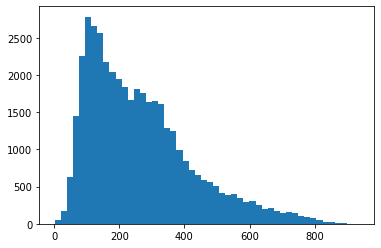

In [5]:
plt.hist(train_data["tokens"].apply(len), bins = 50)
plt.show()

In [6]:
cut_tokens = 60
padding = 0

tokens_aft_cut = []
for i in tokens:
    if len(i) >= cut_tokens:
        tokens_aft_cut.append([wd2ix[word] for word in i[:cut_tokens]])
    elif len(i) < cut_tokens:
        new_i = [wd2ix[word] for word in i]
        new_i += [padding for k in range(cut_tokens-len(i))]
        tokens_aft_cut.append(new_i)

In [7]:
data_X = pd.Series(tokens_aft_cut)
data_y = train_data["vec"].apply(eval)

In [14]:
x = sum(data_y.apply(sum)) / (len(data_y) * 17)

In [15]:
pos_weight = (1-x)/x

In [17]:
from sklearn.model_selection import train_test_split

train_X, test_X, train_y, test_y = train_test_split(data_X, data_y, test_size=0.333)

In [21]:
# Original code is from https://github.com/spro/practical-pytorch
import time
import math
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader

#from name_dataset import NameDataset
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

# Parameters and DataLoaders
HIDDEN_SIZE = 100
N_CHARS = 9758  # ASCII
N_CLASSES = 17


class RNNClassifier(nn.Module):

    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNNClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, input):
        # Note: we run this all at once (over the whole input sequence)

        # input = B x S . size(0) = B
        batch_size = input.size(0)
        # input:  B x S  -- (transpose) --> S x B
        input = input.t()
        # Embedding S x B -> S x B x I (embedding size)
        print("  input", input.size())
        embedded = self.embedding(input)
        #print(embedded)

        # Make a hidden
        hidden = self._init_hidden(batch_size)
        print("embedded: {}, hidden: {}".format(embedded.size(), hidden.size()))
        output, hidden = self.gru(embedded, hidden)
        print("  gru hidden output", output.size())
        print(" gru hidden size: ", hidden.size())
        #print(output)
        # Use the last layer output as FC's input
        # No need to unpack, since we are going to use hidden
        fc_output = self.fc(output[-1,:,:]).reshape(batch_size,N_CLASSES)
        print("  fc output", fc_output.size())
        #print(fc_output)
        return torch.sigmoid(fc_output)

    def _init_hidden(self, batch_size):
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_size)
        return Variable(hidden)
    
    
inputs = Variable(torch.LongTensor(train_X.tolist()))
labels = Variable(torch.LongTensor(train_y.tolist()))

classifier = RNNClassifier(N_CHARS, HIDDEN_SIZE, N_CLASSES)
criterion = torch.nn.BCEWithLogitsLoss(pos_weight = Variable(torch.Tensor([pos_weight for i in range(17)])))
optimizer = torch.optim.Adam(classifier.parameters(), lr=0.05)

#labels = labels.squeeze(1)
for epoch in range(50):
    outputs = classifier(inputs)
    optimizer.zero_grad()
    print(outputs.size())
    loss = criterion(outputs, labels.float())
    loss.backward()
    optimizer.step()
    print(outputs)
    print("epoch: %d, loss: %1.3f" % (epoch + 1, loss.item()))
    print("Accuracy: ", ((outputs > .5)== labels).sum().tolist() / (labels.size(0) * labels.size(1)))
    pred = classifier(Variable(torch.LongTensor(test_X.tolist())))
    true_y = Variable(torch.LongTensor(test_y.tolist()))
    print("Test Set Accuracy: ", ((pred > .5) == true_y).sum().tolist() / (true_y.size(0) * true_y.size(1)))
    #res = []
    #for i in range(len(outputs)):
    #    res.append([train_data.columns[4:-1][idx] for idx in (outputs[i]>.5).nonzero().flatten().tolist()])
    #print("Predicted : ", ''.join())

print("Learning finished!")    
    

  input torch.Size([60, 27971])
embedded: torch.Size([60, 27971, 100]), hidden: torch.Size([1, 27971, 100])
  gru hidden output torch.Size([60, 27971, 100])
 gru hidden size:  torch.Size([1, 27971, 100])
  fc output torch.Size([27971, 17])
torch.Size([27971, 17])
tensor([[0.4734, 0.5510, 0.5052,  ..., 0.4950, 0.4521, 0.4651],
        [0.4734, 0.5510, 0.5052,  ..., 0.4950, 0.4521, 0.4651],
        [0.4734, 0.5510, 0.5052,  ..., 0.4950, 0.4521, 0.4651],
        ...,
        [0.4734, 0.5510, 0.5052,  ..., 0.4950, 0.4521, 0.4651],
        [0.4734, 0.5510, 0.5052,  ..., 0.4950, 0.4521, 0.4651],
        [0.4734, 0.5510, 0.5052,  ..., 0.4950, 0.4521, 0.4651]],
       grad_fn=<SigmoidBackward>)
epoch: 1, loss: 1.269
Accuracy:  0.5771040173961687
  input torch.Size([60, 13965])
embedded: torch.Size([60, 13965, 100]), hidden: torch.Size([1, 13965, 100])
  gru hidden output torch.Size([60, 13965, 100])
 gru hidden size:  torch.Size([1, 13965, 100])
  fc output torch.Size([13965, 17])
Test Set Acc

tensor([[9.9998e-01, 1.6982e-05, 2.1388e-05,  ..., 1.0905e-05, 1.3150e-05,
         1.8700e-05],
        [9.9999e-01, 3.1978e-06, 3.5156e-06,  ..., 3.5615e-06, 4.4693e-06,
         3.3780e-06],
        [1.0000e+00, 1.3542e-06, 2.3004e-06,  ..., 1.2904e-06, 2.2736e-06,
         6.5506e-07],
        ...,
        [1.0000e+00, 1.4407e-06, 2.4411e-06,  ..., 1.1049e-06, 2.2309e-06,
         6.6318e-07],
        [1.0000e+00, 2.0781e-06, 3.3110e-06,  ..., 1.2535e-06, 3.3971e-06,
         1.0524e-06],
        [1.0000e+00, 2.4778e-06, 2.6970e-06,  ..., 1.7682e-06, 4.0537e-06,
         1.8050e-06]], grad_fn=<SigmoidBackward>)
epoch: 8, loss: 1.119
Accuracy:  0.8347237790400562
  input torch.Size([60, 13965])
embedded: torch.Size([60, 13965, 100]), hidden: torch.Size([1, 13965, 100])
  gru hidden output torch.Size([60, 13965, 100])
 gru hidden size:  torch.Size([1, 13965, 100])
  fc output torch.Size([13965, 17])
Test Set Accuracy:  0.8325519681556833
  input torch.Size([60, 27971])
embedded: torc

Test Set Accuracy:  0.8371432783639772
  input torch.Size([60, 27971])
embedded: torch.Size([60, 27971, 100]), hidden: torch.Size([1, 27971, 100])
  gru hidden output torch.Size([60, 27971, 100])
 gru hidden size:  torch.Size([1, 27971, 100])
  fc output torch.Size([27971, 17])
torch.Size([27971, 17])
tensor([[1.0000e+00, 3.1764e-07, 2.2524e-07,  ..., 4.8041e-07, 1.7647e-07,
         4.8919e-07],
        [1.0000e+00, 7.4877e-09, 2.4674e-08,  ..., 3.4360e-09, 2.3321e-08,
         3.9838e-09],
        [1.0000e+00, 6.8112e-09, 2.1451e-08,  ..., 4.8519e-09, 1.7780e-08,
         3.3035e-09],
        ...,
        [1.0000e+00, 7.5483e-09, 2.1123e-08,  ..., 4.1778e-09, 1.4909e-08,
         3.1610e-09],
        [1.0000e+00, 2.5837e-08, 7.0488e-08,  ..., 8.5122e-09, 5.9523e-08,
         1.5921e-08],
        [1.0000e+00, 1.1248e-08, 5.6958e-08,  ..., 4.1865e-09, 2.8797e-08,
         6.1860e-09]], grad_fn=<SigmoidBackward>)
epoch: 15, loss: 1.108
Accuracy:  0.84610531495856
  input torch.Size([60,

embedded: torch.Size([60, 13965, 100]), hidden: torch.Size([1, 13965, 100])
  gru hidden output torch.Size([60, 13965, 100])
 gru hidden size:  torch.Size([1, 13965, 100])
  fc output torch.Size([13965, 17])
Test Set Accuracy:  0.8152692656009772
  input torch.Size([60, 27971])
embedded: torch.Size([60, 27971, 100]), hidden: torch.Size([1, 27971, 100])
  gru hidden output torch.Size([60, 27971, 100])
 gru hidden size:  torch.Size([1, 27971, 100])
  fc output torch.Size([27971, 17])
torch.Size([27971, 17])
tensor([[1.0000e+00, 1.5314e-08, 1.0333e-08,  ..., 4.9089e-08, 8.7778e-09,
         2.5533e-08],
        [1.0000e+00, 3.4649e-10, 1.0386e-09,  ..., 1.5533e-10, 9.0062e-10,
         1.1374e-10],
        [1.0000e+00, 2.9808e-10, 1.1206e-09,  ..., 3.0112e-10, 7.4126e-10,
         1.5677e-10],
        ...,
        [1.0000e+00, 3.5770e-10, 1.0662e-09,  ..., 3.1009e-10, 8.0199e-10,
         1.5071e-10],
        [1.0000e+00, 2.5543e-09, 8.4073e-09,  ..., 8.3750e-10, 8.0070e-09,
         1.67

embedded: torch.Size([60, 13965, 100]), hidden: torch.Size([1, 13965, 100])
  gru hidden output torch.Size([60, 13965, 100])
 gru hidden size:  torch.Size([1, 13965, 100])
  fc output torch.Size([13965, 17])
Test Set Accuracy:  0.8313009414292033
  input torch.Size([60, 27971])
embedded: torch.Size([60, 27971, 100]), hidden: torch.Size([1, 27971, 100])
  gru hidden output torch.Size([60, 27971, 100])
 gru hidden size:  torch.Size([1, 27971, 100])
  fc output torch.Size([27971, 17])
torch.Size([27971, 17])
tensor([[1.0000e+00, 7.4280e-09, 4.4521e-09,  ..., 2.4252e-08, 3.4276e-09,
         1.4988e-08],
        [1.0000e+00, 1.3156e-10, 5.1971e-10,  ..., 3.6203e-11, 3.4659e-10,
         5.0311e-11],
        [1.0000e+00, 8.4566e-11, 3.5317e-10,  ..., 7.7541e-11, 2.1394e-10,
         4.0606e-11],
        ...,
        [1.0000e+00, 1.1297e-10, 3.5870e-10,  ..., 6.8174e-11, 2.7148e-10,
         4.2293e-11],
        [1.0000e+00, 6.8154e-10, 3.4852e-09,  ..., 1.5315e-10, 2.3925e-09,
         4.87

embedded: torch.Size([60, 13965, 100]), hidden: torch.Size([1, 13965, 100])
  gru hidden output torch.Size([60, 13965, 100])
 gru hidden size:  torch.Size([1, 13965, 100])
  fc output torch.Size([13965, 17])
Test Set Accuracy:  0.8361028621975106
  input torch.Size([60, 27971])
embedded: torch.Size([60, 27971, 100]), hidden: torch.Size([1, 27971, 100])
  gru hidden output torch.Size([60, 27971, 100])
 gru hidden size:  torch.Size([1, 27971, 100])
  fc output torch.Size([27971, 17])
torch.Size([27971, 17])
tensor([[1.0000e+00, 1.3007e-09, 2.1477e-09,  ..., 2.4578e-09, 1.1213e-09,
         2.1352e-09],
        [1.0000e+00, 4.8809e-11, 2.2517e-10,  ..., 1.2127e-11, 1.5622e-10,
         1.9432e-11],
        [1.0000e+00, 1.0616e-10, 4.8990e-10,  ..., 5.9045e-11, 2.8022e-10,
         4.6041e-11],
        ...,
        [1.0000e+00, 1.3554e-10, 3.3966e-10,  ..., 9.0697e-11, 2.8075e-10,
         5.1598e-11],
        [1.0000e+00, 1.8391e-10, 1.2407e-09,  ..., 4.0526e-11, 8.2178e-10,
         1.27

KeyboardInterrupt: 